<a href="https://colab.research.google.com/github/giuliafazzi/adversarial-attacks/blob/main/Adversarial_Attacks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Adversarial Attacks**

## 🖥️ **Setup environment**

### **Import libraries**

In [ ]:
from torchvision import models
import torch
from torchvision.io.image import read_image
from torchvision.transforms.functional import to_pil_image
from torchvision import transforms
import torch.nn as nn


from PIL import Image

import matplotlib.pyplot as plt
import numpy as np

## 🧑‍💻 **Define functions**

### `show`:
Function to display an image on the screen



**Parameters:**

*   `image`: Image to be plotted

In [ ]:
def show(image):
  plt.imshow(img)
  plt.axis('off')
  plt.tight_layout()
  plt.show()

### `load_image`:
Function to load an image given the path

**Parameters:**

* `path`: Path to the image to be loaded

**Return:**

* `image`: Image as PIL.Image



In [ ]:
def load_image(path):
  image = Image.open(path).convert("RGB")

  return image

## 🖼️ **Image Classifier**

In [ ]:
class ResNet50:
  def __init__(self, train = False):
    self.weights = models.ResNet50_Weights.DEFAULT
    self.model = models.resnet50(weights=self.weights)
    self.set_device()

    if not train:
      self.eval_model()

  def set_device(self):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    self.model.to(device)

  def preprocess(self, image):
    preprocess = self.weights.transforms(antialias=True)

    return preprocess(image)

  def eval_model(self):
    self.model.eval()

  def predict(self, image, preprocess = True, k = 5):
    if preprocess:
      image = self.preprocess(image).unsqueeze(0)

    output = self.model(image)
    prediction = output.squeeze(0).softmax(0)

    k_probs, k_ids = torch.topk(prediction, k)

    for conf, cat_id in zip(k_probs, k_ids):
      print(f'Confidence {conf:.2%}\tCategory: {self.weights.meta["categories"][cat_id]}')

    return image, output, k_probs, k_ids, self.model

## 🎯 **FGSM (Fast Gradient Sign Method)**

$adv\_x = x + \epsilon*\text{sign}(\nabla_xJ(\theta, x, y))$

adv_x : Adversarial image.

x : Original input image.

y : Original input label.

$\epsilon$ : Multiplier to ensure the perturbations are small.

$\theta$ : Model parameters.

$J$ : Loss.

In [ ]:
def fgsm(image, model, label, epsilon):
  image.requires_grad = True
  x = model(image)
  loss = nn.CrossEntropyLoss()(x, torch.tensor([label]))

  model.zero_grad()
  loss.backward()

  data_grad = image.grad.data.sign()

  perturbation = epsilon * data_grad

  adversarial_image = image + perturbation

  return adversarial_image.detach()

## ▶️ **Run**

### **Load image and classifier**

In [ ]:
resnet = ResNet50()

In [ ]:
img = load_image("data/panda.jpeg")

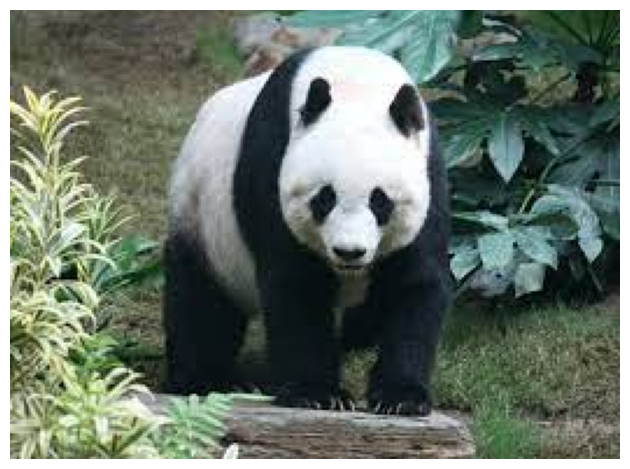

In [ ]:
show(img)

In [ ]:
batch, output, k_probs, k_ids, model = resnet.predict(img)

Confidence 57.22%	Category: giant panda
Confidence 0.86%	Category: lesser panda
Confidence 0.22%	Category: badger
Confidence 0.19%	Category: Sussex spaniel
Confidence 0.18%	Category: patas


### **Run FGSM**

In [ ]:
adv_image = fgsm(image=batch, model=model, label=k_ids[0], epsilon=0.5)

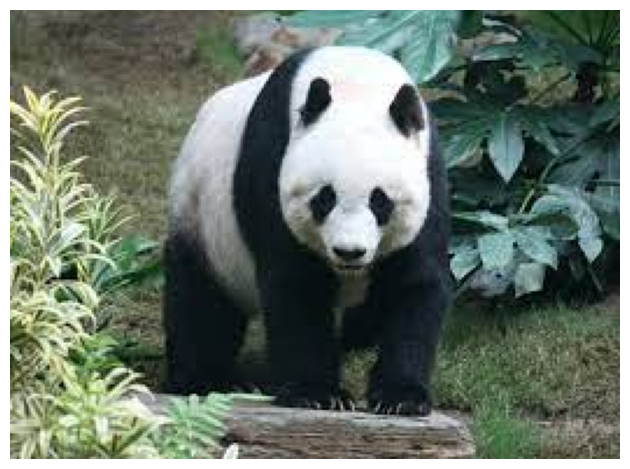

In [ ]:
show(adv_image)

In [ ]:
batch, output, k_probs, k_ids, model = resnet.predict(adv_image, preprocess = False)

Confidence 22.11%	Category: Gila monster
Confidence 1.71%	Category: comic book
Confidence 1.19%	Category: book jacket
Confidence 1.01%	Category: banded gecko
Confidence 0.80%	Category: common iguana


## 💡 **What to improve?**



* Epsilon calculated according to the image
* Add more attackers
* Compare metrics

